In [1]:
from collections import defaultdict
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from gtda.homology import VietorisRipsPersistence
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
#data import
import wget
import urllib

# regex
import re

#time
import pytz as tz
from datetime import datetime

#data explore
import numpy as np
np.random.seed(1337)

#support for reading excel files
import xlrd

# dataframes in python
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

In [4]:
df = pd.read_excel(r'D:\default of credit card clients.xls', header=1)

In [5]:
df

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1      20000    2          2         1   24      2      2     -1   
1          2     120000    2          2         2   26     -1      2      0   
2          3      90000    2          2         2   34      0      0      0   
3          4      50000    2          2         1   37      0      0      0   
4          5      50000    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996     220000    1          3         1   39      0      0      0   
29996  29997     150000    1          3         2   43     -1     -1     -1   
29997  29998      30000    1          2         2   37      4      3      2   
29998  29999      80000    1          3         1   41      1     -1      0   
29999  30000      50000    1          2         1   46      0      0      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0         -1  ...          0          0          0         0       689   
1          0  ...       3272       3455       3261         0      1000   
2          0  ...      14331      14948      15549      1518      1500   
3          0  ...      28314      28959      29547      2000      2019   
4          0  ...      20940      19146      19131      2000     36681   
...      ...  ...        ...        ...        ...       ...       ...   
29995      0  ...      88004      31237      15980      8500     20000   
29996     -1  ...       8979       5190          0      1837      3526   
29997     -1  ...      20878      20582      19357         0         0   
29998      0  ...      52774      11855      48944     85900      3409   
29999      0  ...      36535      32428      15313      2078      1800   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0             0         0         0         0                           1  
1          1000      1000         0      2000                           1  
2          1000      1000      1000      5000                           0  
3          1200      1100      1069      1000                           0  
4         10000      9000       689       679                           0  
...         ...       ...       ...       ...                         ...  
29995      5003      3047      5000      1000                           0  
29996      8998       129         0         0                           0  
29997     22000      4200      2000      3100                           1  
29998      1178      1926     52964      1804                           1  
29999      1430      1000      1000      1000                           1  

[30000 rows x 25 columns]

In [6]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

In [7]:
print("Explanatory variables:  {}".format(len(df.columns)-1))
print("Number of Observations: {}".format(df.shape[0]))

df['target'] = df['default payment next month'].astype('category')

# create a 'target' column for our own convenience
print("Target variable:       '{}' -> '{}'".format('default payment next month', 'target'))

Explanatory variables:  23
Number of Observations: 30000
Target variable:       'default payment next month' -> 'target'


In [8]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

df[pay_status_columns].head(10)

pay_1  pay_2  pay_3  pay_4  pay_5  pay_6
0      2      2     -1     -1     -2     -2
1     -1      2      0      0      0      2
2      0      0      0      0      0      0
3      0      0      0      0      0      0
4     -1      0     -1      0      0      0
5      0      0      0      0      0      0
6      0      0      0      0      0      0
7      0     -1     -1      0      0     -1
8      0      0      2      0      0      0
9     -2     -2     -2     -2     -1     -1

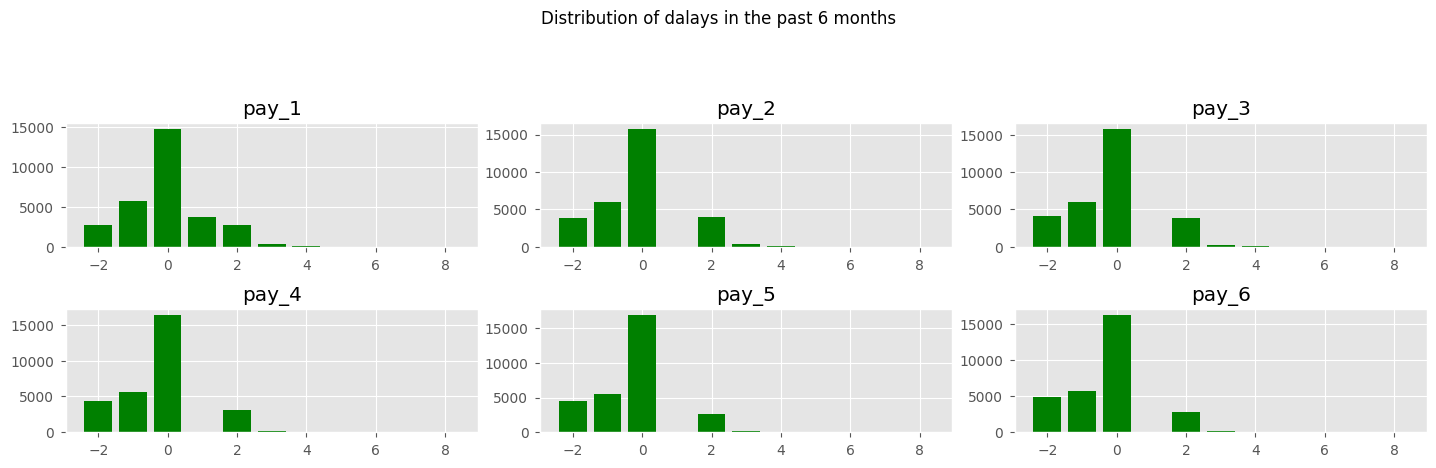

In [9]:
# pay status columns
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of dalays in the past 6 months')

for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = df[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='g')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

In [10]:
# bill columns
pattern = re.compile("^bill_amt[0-9]+$")
bill_columns = [ x for x in df.columns if (pattern.match(x))]
df[bill_columns].describe()

bill_amt1      bill_amt2     bill_amt3      bill_amt4  \
count   30000.000000   30000.000000  3.000000e+04   30000.000000   
mean    51223.330900   49179.075167  4.701315e+04   43262.948967   
std     73635.860576   71173.768783  6.934939e+04   64332.856134   
min   -165580.000000  -69777.000000 -1.572640e+05 -170000.000000   
25%      3558.750000    2984.750000  2.666250e+03    2326.750000   
50%     22381.500000   21200.000000  2.008850e+04   19052.000000   
75%     67091.000000   64006.250000  6.016475e+04   54506.000000   
max    964511.000000  983931.000000  1.664089e+06  891586.000000   

           bill_amt5      bill_amt6  
count   30000.000000   30000.000000  
mean    40311.400967   38871.760400  
std     60797.155770   59554.107537  
min    -81334.000000 -339603.000000  
25%      1763.000000    1256.000000  
50%     18104.500000   17071.000000  
75%     50190.500000   49198.250000  
max    927171.000000  961664.000000

In [11]:
# pay status columns
pattern = re.compile("^pay_amt[0-9]+$")
pay_amount_columns = [ x for x in df.columns if (pattern.match(x))]
df[pay_amount_columns].describe()

pay_amt1      pay_amt2      pay_amt3       pay_amt4  \
count   30000.000000  3.000000e+04   30000.00000   30000.000000   
mean     5663.580500  5.921163e+03    5225.68150    4826.076867   
std     16563.280354  2.304087e+04   17606.96147   15666.159744   
min         0.000000  0.000000e+00       0.00000       0.000000   
25%      1000.000000  8.330000e+02     390.00000     296.000000   
50%      2100.000000  2.009000e+03    1800.00000    1500.000000   
75%      5006.000000  5.000000e+03    4505.00000    4013.250000   
max    873552.000000  1.684259e+06  896040.00000  621000.000000   

            pay_amt5       pay_amt6  
count   30000.000000   30000.000000  
mean     4799.387633    5215.502567  
std     15278.305679   17777.465775  
min         0.000000       0.000000  
25%       252.500000     117.750000  
50%      1500.000000    1500.000000  
75%      4031.500000    4000.000000  
max    426529.000000  528666.000000

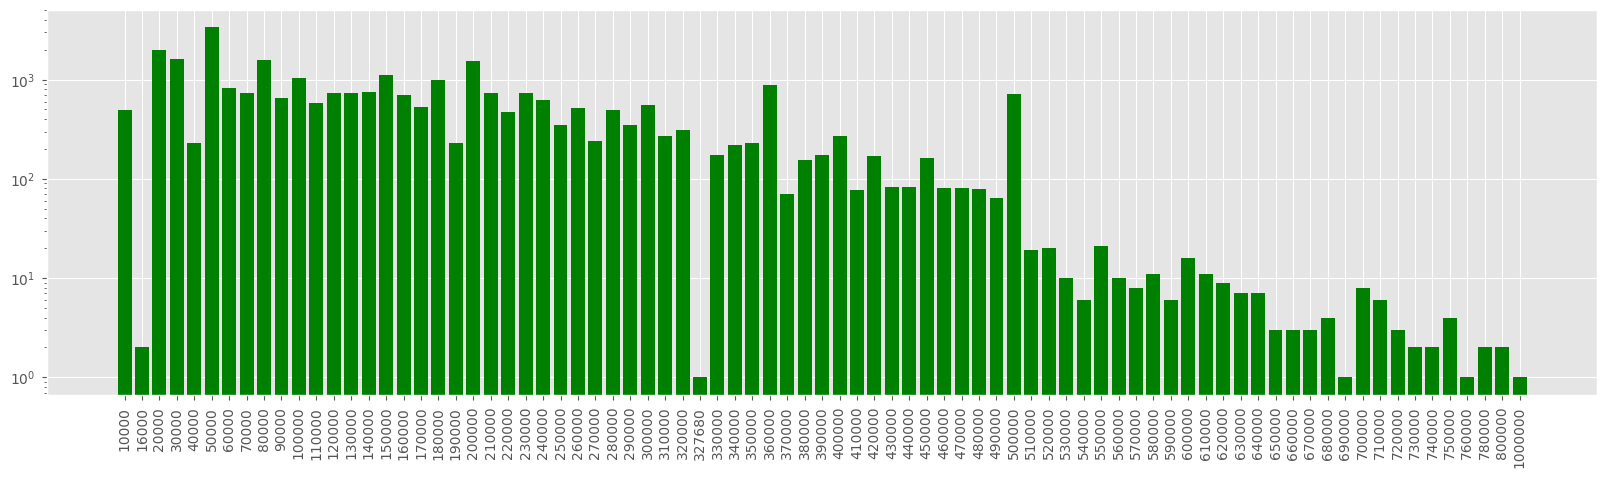

In [12]:
# limit balance
fig = plt.figure()
fig.set_size_inches(20,5)
ax = fig.add_subplot(111)

d = df.groupby(['limit_bal']).size()
ax.set_yscale("log")
ax.set_xticks(np.arange(len(d)))
ax.set_xticklabels(['%d' % i for i in d.index], rotation='vertical')
p = ax.bar(np.arange(len(d)), d, color='green')

defaulting accounts are 22.12% out of 30000 observations


C:\Users\Babua\AppData\Local\Temp\ipykernel_10096\297017344.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = df.groupby(['target']).size()


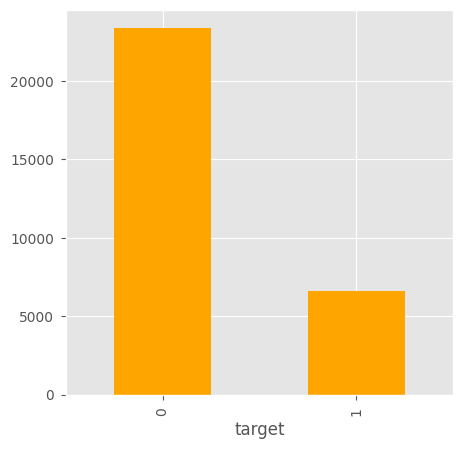

In [13]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = df.groupby(['target']).size()

print("defaulting accounts are {}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='bar', color='orange')

In [14]:
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])

In [15]:
df['age_cat'] = pd.cut(df['age'], range(0, 100, 10), right=False)

In [16]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]
for i in pay_status_columns:
    df[i] = df[i].astype('category')

C:\Users\Babua\AppData\Local\Temp\ipykernel_10096\2773882422.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = df.groupby(['target', 'sex']).size()
C:\Users\Babua\AppData\Local\Temp\ipykernel_10096\2773882422.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = df.groupby(['target', 'marriage']).size()
C:\Users\Babua\AppData\Local\Temp\ipykernel_10096\2773882422.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

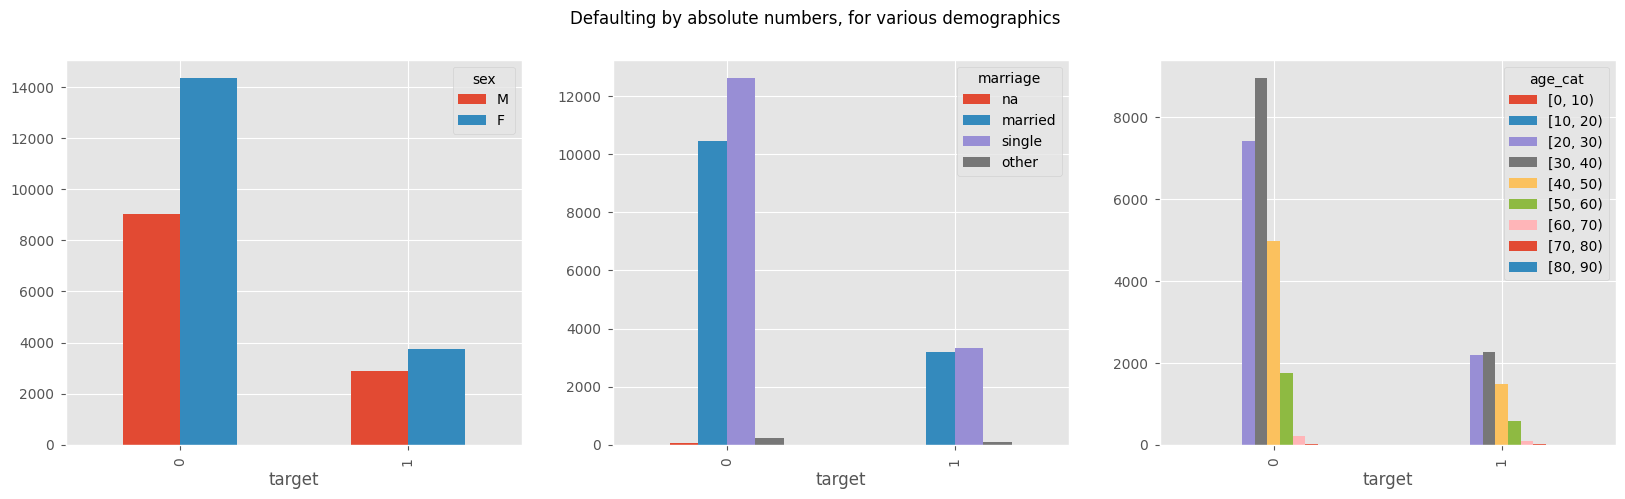

In [17]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

d = df.groupby(['target', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[2])

C:\Users\Babua\AppData\Local\Temp\ipykernel_10096\3137050011.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = df.groupby(['target', 'sex']).size().unstack(level=1)
C:\Users\Babua\AppData\Local\Temp\ipykernel_10096\3137050011.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = df.groupby(['target', 'marriage']).size().unstack(level=1)
C:\Users\Babua\AppData\Local\Temp\ipykernel_10096\3137050011.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

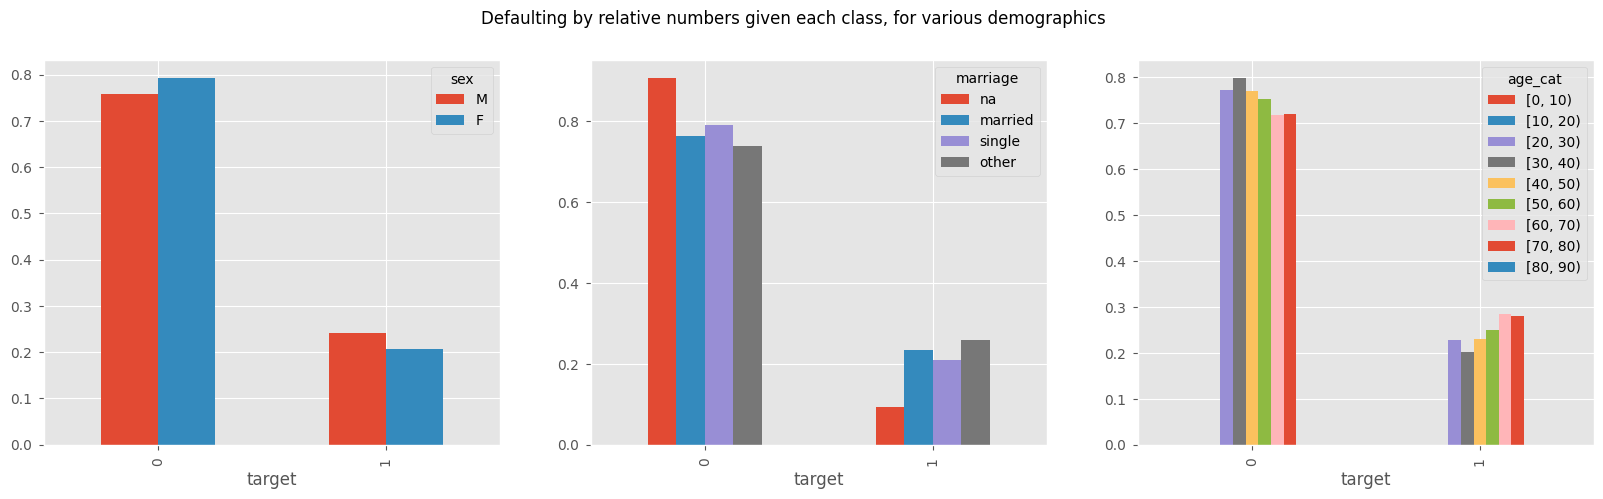

In [18]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by relative numbers given each class, for various demographics')

d = df.groupby(['target', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

In [19]:
# help func
def selcols(prefix, a=1, b=6):
    return [prefix+str(i) for i in np.arange(a,b+1)]

In [20]:
from math import log

# average and standard deviation payment status
df['pay_avg'] = df[selcols('pay_')].mean(axis=1)
df['pay_std'] = df[selcols('pay_')].std(axis=1)

In [21]:
# average payment
df['pay_amt_avg']     = df[selcols('pay_amt')].mean(axis=1)

# log of average
df['pay_amt_avg_log'] = df['pay_amt_avg'].apply(lambda x: log(x+1))

#amounts relative to the average payment
for i in np.arange(1,7):
    df['pay_relamt'+str(i)] = df['pay_amt'+str(i)]/df['pay_amt_avg']

# log of payments
for i in np.arange(1,7):
    df['pay_amt_log'+str(i)] = df['pay_amt'+str(i)].apply(lambda x: log(x+1))

In [22]:
# average bill
df['bill_amt_avg'] = df[selcols('bill_amt')].mean(axis=1)
df['bill_amt_avg_log'] = df['bill_amt_avg'].apply(lambda x: log(x+1) if x>0 else 0)

# bill sign as a separate feature
for i in np.arange(1,7):
    df['bill_amt_sign'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: float(x>0))
    
# bill log as a separate feature (0 if bill is negative)
for i in np.arange(1,7):
    df['bill_amt_log'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: log(x+1) if x>0 else 0)
    
#bill amounts relative to the limit
for i in np.arange(1,7):
    df['bill_relamt'+str(i)] = df['bill_amt'+str(i)]/df['limit_bal']

In [23]:
#log of credit limit
df['limit_bal_log'] = df['limit_bal'].apply(lambda x: log(x+1))
df['limit_bal_cat'] = pd.cut(df['limit_bal'], range(0, int(1e6), 10000), right=False)

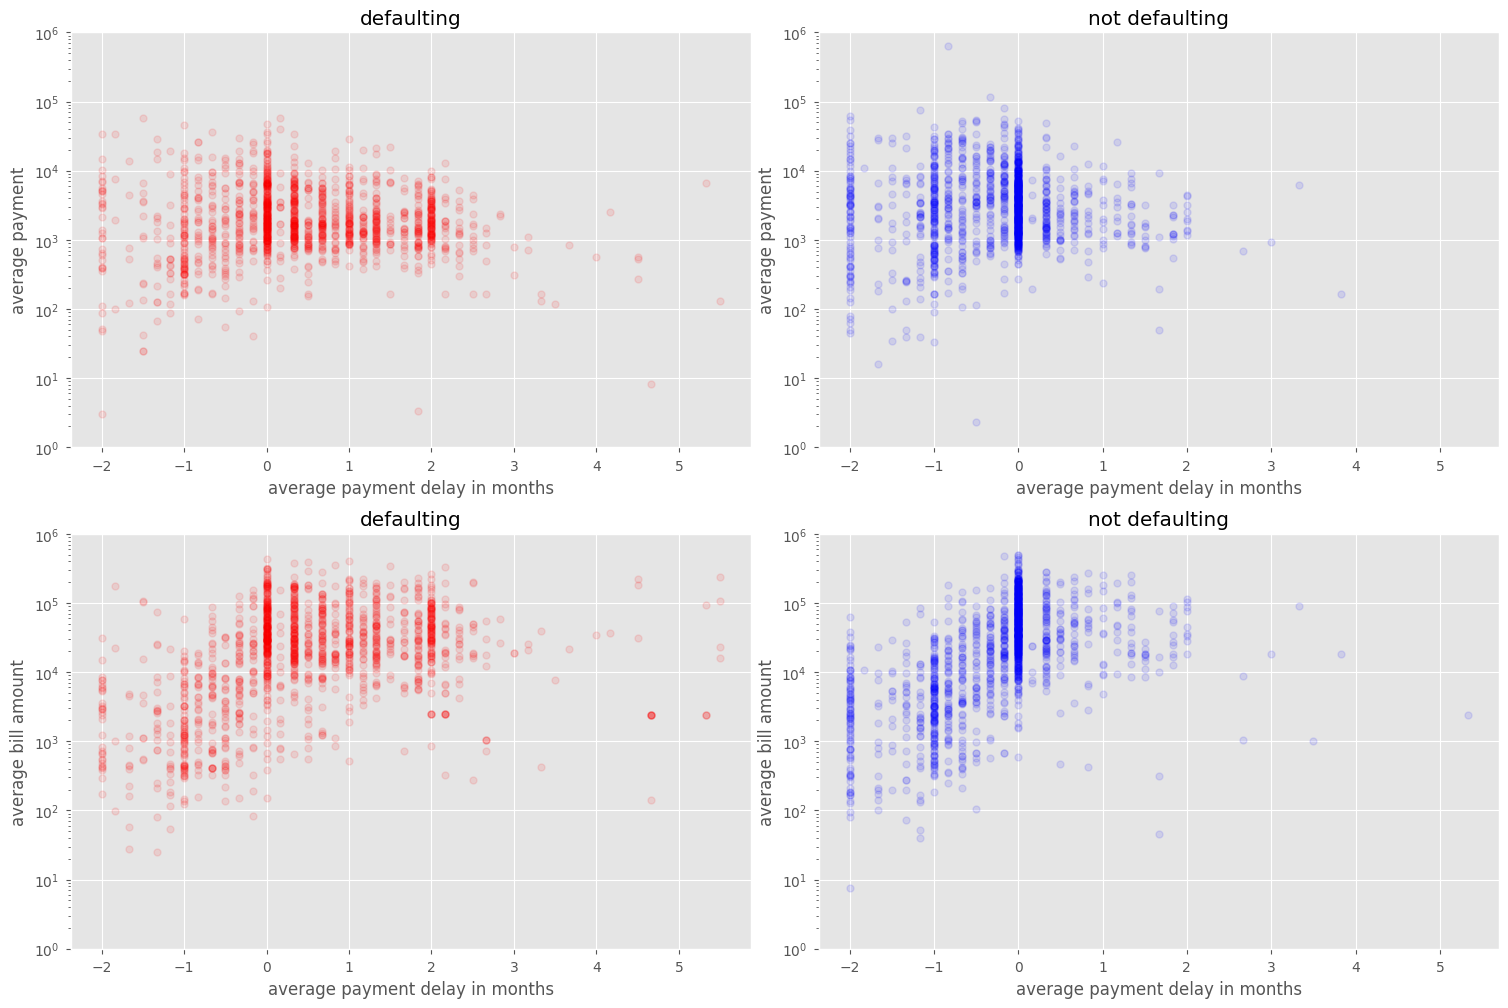

In [24]:
def_no = df[df['target']==0].sample(1500)
def_yes  = df[df['target']==1].sample(1500)

fig,ax = plt.subplots(2,2)
fig.set_size_inches(15,10)

ax[0,0].set_ylim([1,1e6])
ax[0,0].set_title('defaulting')
ax[0,0].set_ylabel('average payment')
ax[0,0].set_xlabel('average payment delay in months')
p = ax[0,0].semilogy(def_yes['pay_avg'], def_yes['pay_amt_avg'], 'ro', markersize=5, alpha=0.1)

ax[0,1].set_ylim([1,1e6])
ax[0,1].set_title('not defaulting')
ax[0,1].set_ylabel('average payment')
ax[0,1].set_xlabel('average payment delay in months')
p = ax[0,1].semilogy(def_no['pay_avg'], def_no['pay_amt_avg'], 'bo', markersize=5, alpha=0.1)

ax[1,0].set_ylim([1,1e6])
ax[1,0].set_title('defaulting')
ax[1,0].set_ylabel('average bill amount')
ax[1,0].set_xlabel('average payment delay in months')
p = ax[1,0].semilogy(def_yes['pay_avg'], def_yes['bill_amt_avg'], 'ro', markersize=5, alpha=0.1)

ax[1,1].set_ylim([1,1e6])
ax[1,1].set_title('not defaulting')
ax[1,1].set_ylabel('average bill amount')
ax[1,1].set_xlabel('average payment delay in months')
p = ax[1,1].semilogy(def_no['pay_avg'], def_no['bill_amt_avg'], 'bo', markersize=5, alpha=0.1)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [25]:
from patsy import dmatrices

formula  = 'target ~ '

# original features
formula += 'C(sex) + C(marriage) +  C(education) + age'
formula += '+' + '+'.join(selcols('pay_'))

#### engineered / normalized features

# categorical age and credit limit (binned)
formula += '+' + 'C(age_cat)'
formula += '+' + 'C(limit_bal_cat) + limit_bal_log'

#pay delays
formula += '+' + 'pay_avg + pay_std'
    
#pay_amt
formula += '+' + 'pay_amt_avg_log'
formula += '+' + '+'.join(selcols('pay_relamt'))
formula += '+' + '+'.join(selcols('pay_amt_log'))

# bill amounts
formula += '+' + 'bill_amt_avg_log'
formula += '+' + '+'.join(selcols('bill_relamt'))
formula += '+' + '+'.join(selcols('bill_amt_sign'))
formula += '+' + '+'.join(selcols('bill_amt_log'))

y, X = dmatrices(formula, data=df, return_type='dataframe')
y = y.iloc[:, 1]

In [26]:
df

limit_bal sex  education marriage  age pay_1 pay_2 pay_3 pay_4 pay_5  \
0          20000   F          2  married   24     2     2    -1    -1    -2   
1         120000   F          2   single   26    -1     2     0     0     0   
2          90000   F          2   single   34     0     0     0     0     0   
3          50000   F          2  married   37     0     0     0     0     0   
4          50000   M          2  married   57    -1     0    -1     0     0   
...          ...  ..        ...      ...  ...   ...   ...   ...   ...   ...   
29995     220000   M          3  married   39     0     0     0     0     0   
29996     150000   M          3   single   43    -1    -1    -1    -1     0   
29997      30000   M          2   single   37     4     3     2    -1     0   
29998      80000   M          3  married   41     1    -1     0     0     0   
29999      50000   M          2  married   46     0     0     0     0     0   

       ... bill_amt_log5  bill_amt_log6  bill_relamt1  bill_relamt2  \
0      ...      0.000000       0.000000      0.195650      0.155100   
1      ...      8.147867       8.090096      0.022350      0.014375   
2      ...      9.612400       9.651816      0.324878      0.155856   
3      ...     10.273671      10.293771      0.939800      0.964660   
4      ...      9.859901       9.859118      0.172340      0.113400   
...    ...           ...            ...           ...           ...   
29995  ...     10.349391       9.679156      0.858855      0.876432   
29996  ...      8.554682       0.000000      0.011220      0.012187   
29997  ...      9.932221       9.870861      0.118833      0.111867   
29998  ...      9.380589      10.798452     -0.020563      0.979738   
29999  ...     10.386808       9.636523      0.958580      0.978100   

       bill_relamt3  bill_relamt4  bill_relamt5  bill_relamt6  limit_bal_log  \
0          0.034450      0.000000      0.000000      0.000000       9.903538   
1          0.022350      0.027267      0.028792      0.027175      11.695255   
2          0.150656      0.159233      0.166089      0.172767      11.407576   
3          0.985820      0.566280      0.579180      0.590940      10.819798   
4          0.716700      0.418800      0.382920      0.382620      10.819798   
...             ...           ...           ...           ...            ...   
29995      0.947114      0.400018      0.141986      0.072636      12.301387   
29996      0.023347      0.059860      0.034600      0.000000      11.918397   
29997      0.091933      0.695933      0.686067      0.645233      10.308986   
29998      0.953800      0.659675      0.148187      0.611800      11.289794   
29999      0.995280      0.730700      0.648560      0.306260      10.819798   

          limit_bal_cat  
0        [20000, 30000)  
1      [120000, 130000)  
2       [90000, 100000)  
3        [50000, 60000)  
4        [50000, 60000)  
...                 ...  
29995  [220000, 230000)  
29996  [150000, 160000)  
29997    [30000, 40000)  
29998    [80000, 90000)  
29999    [50000, 60000)  

[30000 rows x 64 columns]

In [27]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])

In [28]:
import warnings
from sklearn.feature_selection import SelectKBest, f_classif

warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

selector = SelectKBest(f_classif)
selector.fit(X, y)

SelectKBest()

In [29]:
X

Intercept  C(sex)[T.F]  C(marriage)[T.married]  C(marriage)[T.single]  \
0            1.0          1.0                     1.0                    0.0   
1            1.0          1.0                     0.0                    1.0   
2            1.0          1.0                     0.0                    1.0   
3            1.0          1.0                     1.0                    0.0   
4            1.0          0.0                     1.0                    0.0   
...          ...          ...                     ...                    ...   
29995        1.0          0.0                     1.0                    0.0   
29996        1.0          0.0                     0.0                    1.0   
29997        1.0          0.0                     0.0                    1.0   
29998        1.0          0.0                     1.0                    0.0   
29999        1.0          0.0                     1.0                    0.0   

       C(marriage)[T.other]  C(education)[T.1]  C(education)[T.2]  \
0                       0.0                0.0                1.0   
1                       0.0                0.0                1.0   
2                       0.0                0.0                1.0   
3                       0.0                0.0                1.0   
4                       0.0                0.0                1.0   
...                     ...                ...                ...   
29995                   0.0                0.0                0.0   
29996                   0.0                0.0                0.0   
29997                   0.0                0.0                1.0   
29998                   0.0                0.0                0.0   
29999                   0.0                0.0                1.0   

       C(education)[T.3]  C(education)[T.4]  C(education)[T.5]  ...  \
0                    0.0                0.0                0.0  ...   
1                    0.0                0.0                0.0  ...   
2                    0.0                0.0                0.0  ...   
3                    0.0                0.0                0.0  ...   
4                    0.0                0.0                0.0  ...   
...                  ...                ...                ...  ...   
29995                1.0                0.0                0.0  ...   
29996                1.0                0.0                0.0  ...   
29997                0.0                0.0                0.0  ...   
29998                1.0                0.0                0.0  ...   
29999                0.0                0.0                0.0  ...   

       bill_amt_sign3  bill_amt_sign4  bill_amt_sign5  bill_amt_sign6  \
0                 1.0             0.0             0.0             0.0   
1                 1.0             1.0             1.0             1.0   
2                 1.0             1.0             1.0             1.0   
3                 1.0             1.0             1.0             1.0   
4                 1.0             1.0             1.0             1.0   
...               ...             ...             ...             ...   
29995             1.0             1.0             1.0             1.0   
29996             1.0             1.0             1.0             0.0   
29997             1.0             1.0             1.0             1.0   
29998             1.0             1.0             1.0             1.0   
29999             1.0             1.0             1.0             1.0   

       bill_amt_log1  bill_amt_log2  bill_amt_log3  bill_amt_log4  \
0           8.272315       8.040125       6.536692       0.000000   
1           7.894691       7.453562       7.894691       8.093462   
2          10.283293       9.548811       9.514880       9.570250   
3          10.757711      10.783819      10.805517      10.251147   
4           9.061608       8.643121      10.486708       9.949464   
...              ...            ...            ...            ...   
2999

In [30]:
top_indices = np.nan_to_num(selector.scores_).argsort()[-10:][::-1]
selector.scores_[top_indices]
X.columns[top_indices]

Index(['pay_1[T.2]', 'pay_2[T.2]', 'pay_avg', 'pay_3[T.2]', 'pay_4[T.2]',
       'pay_5[T.2]', 'pay_std', 'pay_6[T.2]', 'pay_1[T.0]', 'limit_bal_log'],
      dtype='object')

In [31]:
top_indices

array([ 14,  24, 177,  34,  44,  53, 178,  62,  12, 176])

In [32]:
X[X.columns[top_indices]].corr()

pay_1[T.2]  pay_2[T.2]   pay_avg  pay_3[T.2]  pay_4[T.2]  \
pay_1[T.2]       1.000000    0.420552  0.412041    0.322803    0.304091   
pay_2[T.2]       0.420552    1.000000  0.525626    0.526637    0.389973   
pay_avg          0.412041    0.525626  1.000000    0.535422    0.540737   
pay_3[T.2]       0.322803    0.526637  0.535422    1.000000    0.542747   
pay_4[T.2]       0.304091    0.389973  0.540737    0.542747    1.000000   
pay_5[T.2]       0.287620    0.356179  0.527080    0.397540    0.581603   
pay_std          0.237676    0.339627  0.272481    0.352038    0.284150   
pay_6[T.2]       0.266179    0.324028  0.497748    0.366851    0.418089   
pay_1[T.0]      -0.321547   -0.395985  0.152417   -0.214728   -0.156545   
limit_bal_log   -0.134707   -0.192539 -0.342820   -0.188792   -0.183322   

               pay_5[T.2]   pay_std  pay_6[T.2]  pay_1[T.0]  limit_bal_log  
pay_1[T.2]       0.287620  0.237676    0.266179   -0.321547      -0.134707  
pay_2[T.2]       0.356179  0.339627    0.324028   -0.395985      -0.192539  
pay_avg          0.527080  0.272481    0.497748    0.152417      -0.342820  
pay_3[T.2]       0.397540  0.352038    0.366851   -0.214728      -0.188792  
pay_4[T.2]       0.581603  0.284150    0.418089   -0.156545      -0.183322  
pay_5[T.2]       1.000000  0.214064    0.589209   -0.137979      -0.163874  
pay_std          0.214064  1.000000    0.220574   -0.366488      -0.178035  
pay_6[T.2]       0.589209  0.220574    1.000000   -0.113164      -0.159945  
pay_1[T.0]      -0.137979 -0.366488   -0.113164    1.000000      -0.087176  
limit_bal_log   -0.163874 -0.178035   -0.159945   -0.087176       1.000000

In [33]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

MinMaxScaler()

In [34]:
from sklearn.pipeline import Pipeline

preprocess = Pipeline([('anova', selector), ('scale', scaler)])
preprocess.fit(X,y)

X_prep = preprocess.transform(X)

In [35]:
X

Intercept  C(sex)[T.F]  C(marriage)[T.married]  C(marriage)[T.single]  \
0            1.0          1.0                     1.0                    0.0   
1            1.0          1.0                     0.0                    1.0   
2            1.0          1.0                     0.0                    1.0   
3            1.0          1.0                     1.0                    0.0   
4            1.0          0.0                     1.0                    0.0   
...          ...          ...                     ...                    ...   
29995        1.0          0.0                     1.0                    0.0   
29996        1.0          0.0                     0.0                    1.0   
29997        1.0          0.0                     0.0                    1.0   
29998        1.0          0.0                     1.0                    0.0   
29999        1.0          0.0                     1.0                    0.0   

       C(marriage)[T.other]  C(education)[T.1]  C(education)[T.2]  \
0                       0.0                0.0                1.0   
1                       0.0                0.0                1.0   
2                       0.0                0.0                1.0   
3                       0.0                0.0                1.0   
4                       0.0                0.0                1.0   
...                     ...                ...                ...   
29995                   0.0                0.0                0.0   
29996                   0.0                0.0                0.0   
29997                   0.0                0.0                1.0   
29998                   0.0                0.0                0.0   
29999                   0.0                0.0                1.0   

       C(education)[T.3]  C(education)[T.4]  C(education)[T.5]  ...  \
0                    0.0                0.0                0.0  ...   
1                    0.0                0.0                0.0  ...   
2                    0.0                0.0                0.0  ...   
3                    0.0                0.0                0.0  ...   
4                    0.0                0.0                0.0  ...   
...                  ...                ...                ...  ...   
29995                1.0                0.0                0.0  ...   
29996                1.0                0.0                0.0  ...   
29997                0.0                0.0                0.0  ...   
29998                1.0                0.0                0.0  ...   
29999                0.0                0.0                0.0  ...   

       bill_amt_sign3  bill_amt_sign4  bill_amt_sign5  bill_amt_sign6  \
0                 1.0             0.0             0.0             0.0   
1                 1.0             1.0             1.0             1.0   
2                 1.0             1.0             1.0             1.0   
3                 1.0             1.0             1.0             1.0   
4                 1.0             1.0             1.0             1.0   
...               ...             ...             ...             ...   
29995             1.0             1.0             1.0             1.0   
29996             1.0             1.0             1.0             0.0   
29997             1.0             1.0             1.0             1.0   
29998             1.0             1.0             1.0             1.0   
29999             1.0             1.0             1.0             1.0   

       bill_amt_log1  bill_amt_log2  bill_amt_log3  bill_amt_log4  \
0           8.272315       8.040125       6.536692       0.000000   
1           7.894691       7.453562       7.894691       8.093462   
2          10.283293       9.548811       9.514880       9.570250   
3          10.757711      10.783819      10.805517      10.251147   
4           9.061608       8.643121      10.486708       9.949464   
...              ...            ...            ...            ...   
2999

In [36]:
data_prep=pd.DataFrame(X_prep,columns=X.columns[top_indices])

In [37]:
data_prep['target']=list(y)

In [38]:
data_prep

pay_1[T.2]  pay_2[T.2]  pay_avg  pay_3[T.2]  pay_4[T.2]  pay_5[T.2]  \
0             0.0         1.0      1.0         0.0         0.0         0.0   
1             0.0         0.0      1.0         0.0         0.0         0.0   
2             1.0         0.0      0.0         0.0         0.0         0.0   
3             1.0         0.0      0.0         0.0         0.0         0.0   
4             0.0         0.0      0.0         0.0         0.0         0.0   
...           ...         ...      ...         ...         ...         ...   
28562         1.0         0.0      0.0         0.0         0.0         0.0   
28563         0.0         0.0      0.0         0.0         0.0         0.0   
28564         0.0         0.0      0.0         1.0         0.0         0.0   
28565         0.0         0.0      0.0         0.0         0.0         0.0   
28566         1.0         0.0      0.0         0.0         0.0         0.0   

       pay_std  pay_6[T.2]  pay_1[T.0]  limit_bal_log  target  
0          0.0    0.158172    0.222222       0.581087     1.0  
1          1.0    0.567060    0.333333       0.382235     1.0  
2          0.0    0.501408    0.266667       0.000000     0.0  
3          0.0    0.367272    0.266667       0.000000     0.0  
4          0.0    0.367272    0.222222       0.161165     0.0  
...        ...         ...         ...            ...     ...  
28562      0.0    0.705385    0.266667       0.000000     0.0  
28563      0.0    0.617983    0.177778       0.161165     0.0  
28564      0.0    0.250699    0.444444       0.613696     1.0  
28565      0.0    0.474529    0.244444       0.234936     1.0  
28566      0.0    0.367272    0.266667       0.000000     1.0  

[28567 rows x 11 columns]

In [39]:
# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_prep[list(set(data_prep.columns) - set(['target']))])

In [40]:
# Step 2: Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

In [41]:
# Step 3: Create a new DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

In [42]:
pca_df['target']=data_prep['target']

<Axes: xlabel='Principal Component 1', ylabel='Principal Component 2'>

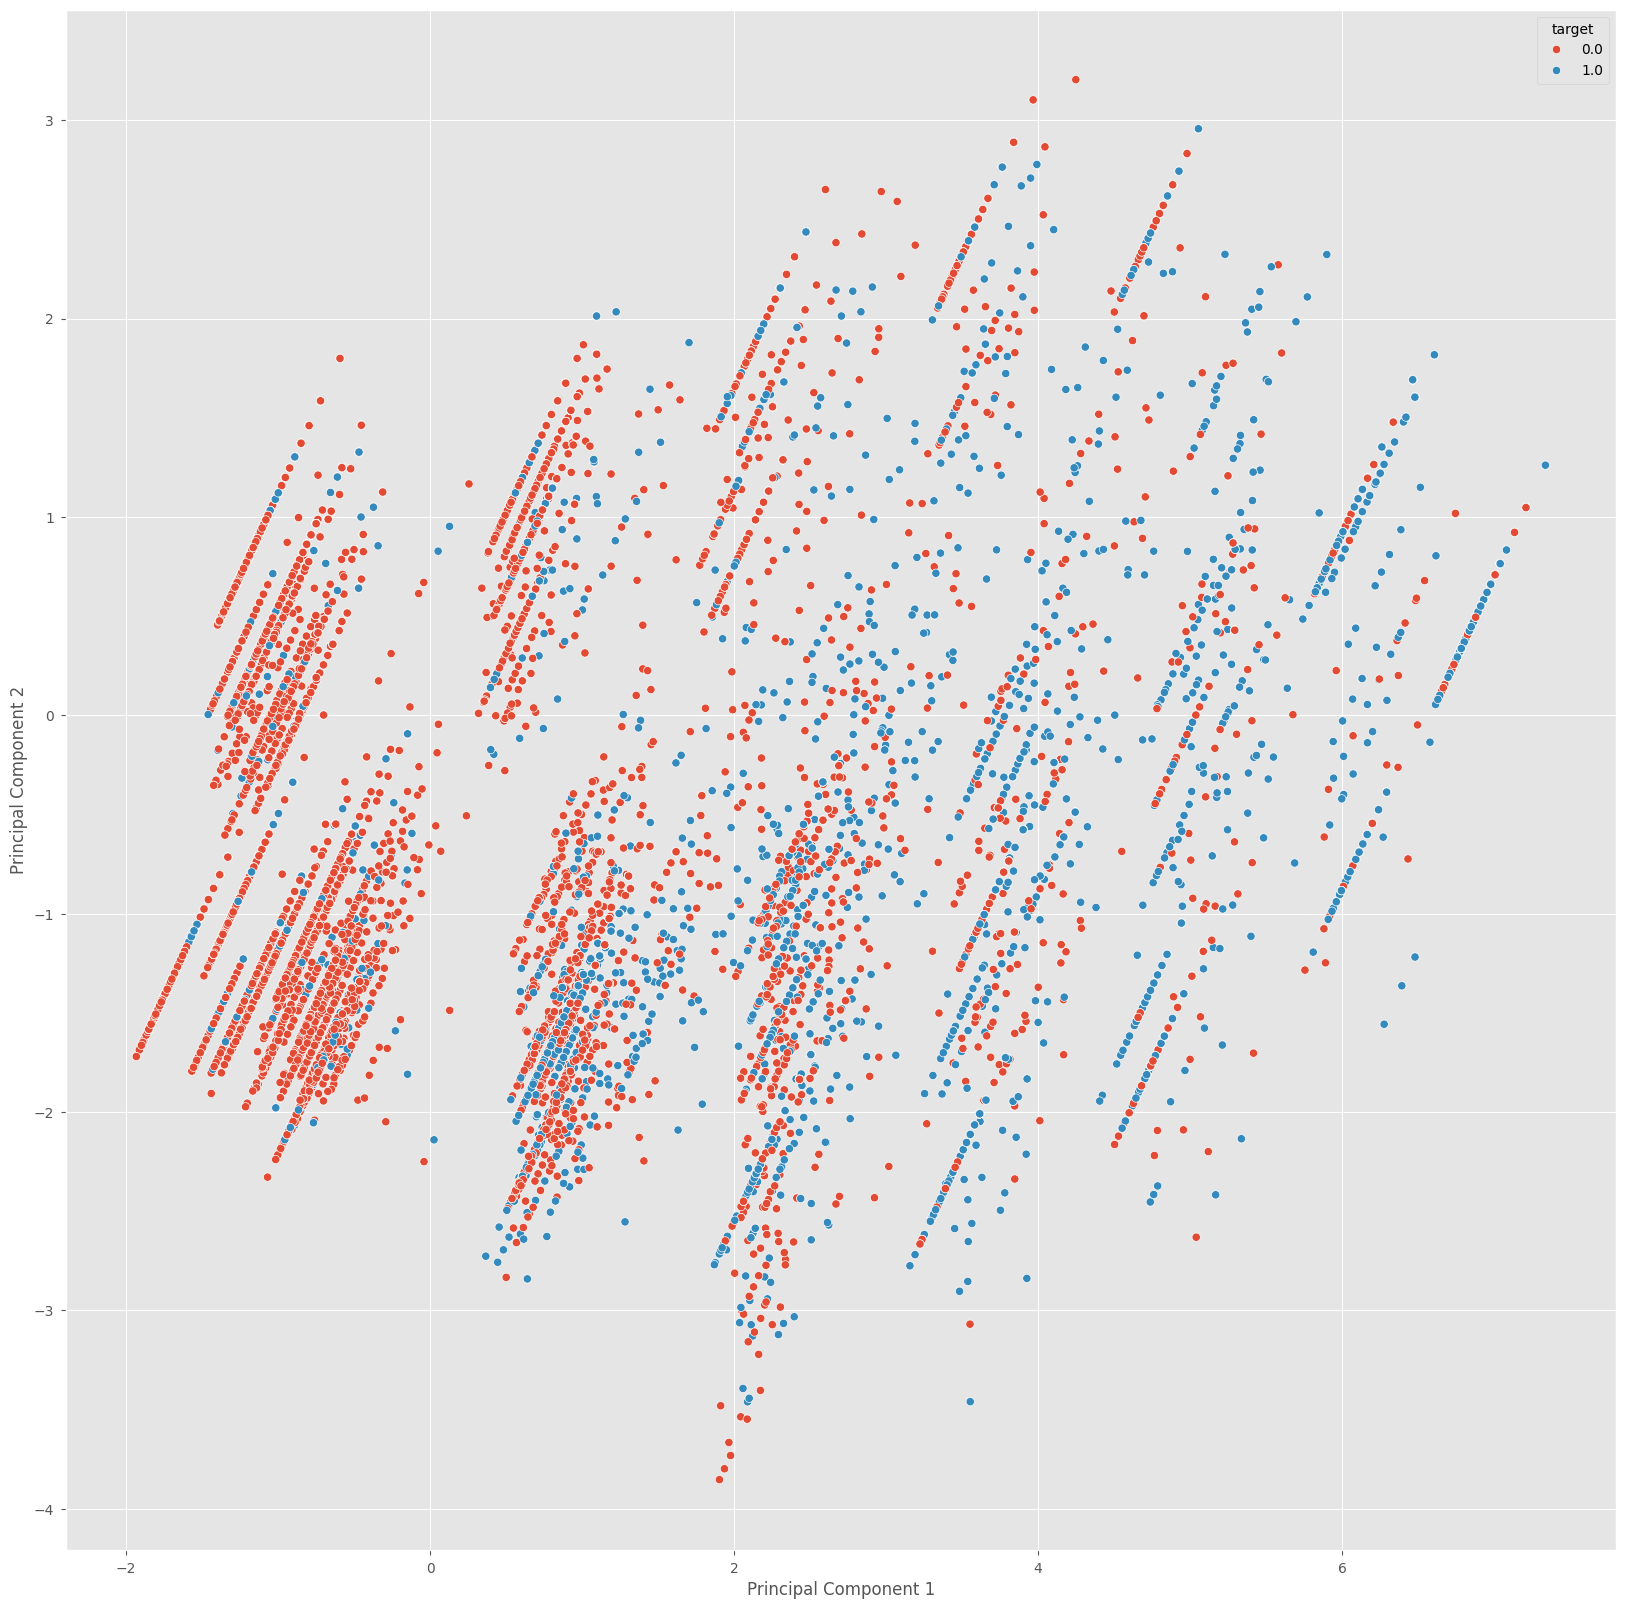

In [43]:
sns.scatterplot(data=pca_df,x='Principal Component 1',y='Principal Component 2',hue='target')

In [44]:
pca_df

Principal Component 1  Principal Component 2  target
0                   2.507685              -2.644639     1.0
1                   2.311254              -1.051588     1.0
2                  -0.998735               1.121642     0.0
3                  -0.890121               1.302955     0.0
4                  -0.445072              -0.589750     0.0
...                      ...                    ...     ...
28562              -1.163899               0.845926     0.0
28563              -0.790517              -1.054533     0.0
28564               2.219071              -0.875161     1.0
28565              -0.338128              -0.830394     1.0
28566              -0.890121               1.302955     1.0

[28567 rows x 3 columns]

In [45]:
pca_df[['Principal Component 1','Principal Component 2']]

Principal Component 1  Principal Component 2
0                   2.507685              -2.644639
1                   2.311254              -1.051588
2                  -0.998735               1.121642
3                  -0.890121               1.302955
4                  -0.445072              -0.589750
...                      ...                    ...
28562              -1.163899               0.845926
28563              -0.790517              -1.054533
28564               2.219071              -0.875161
28565              -0.338128              -0.830394
28566              -0.890121               1.302955

[28567 rows x 2 columns]

In [46]:
pca_df.loc[0:2,['target','Principal Component 1','Principal Component 2']]

target  Principal Component 1  Principal Component 2
0     1.0               2.507685              -2.644639
1     1.0               2.311254              -1.051588
2     0.0              -0.998735               1.121642

In [47]:
import kmapper as km
from sklearn.cluster import DBSCAN

# Initialize the KeplerMapper object
mapper = km.KeplerMapper()
projected_data = mapper.fit_transform(np.array(pca_df[['Principal Component 1','Principal Component 2']]))
# Create a cover for the Mapper algorithm
cover = km.Cover(n_cubes=10, perc_overlap=0.5)
# Map the projected data to create a graph using DBSCAN for clustering
graph = mapper.map(projected_data,
                    X=np.array(pca_df[['Principal Component 1','Principal Component 2']]),
                    clusterer=DBSCAN(eps=0.5, min_samples=100),
                    cover=cover)


In [71]:
mapper.visualize(graph,
                 path_html="mapper_output.html",
                 title="Mapper Output with Anomalies",
                 )
from IPython.display import IFrame
IFrame('mapper_output.html', width='100%', height=700)

In [49]:
reverse_mapping = {}
for key, indices in graph['nodes'].items():
    for index in indices:
        if index not in reverse_mapping:
            reverse_mapping[index] = []
        reverse_mapping[index].append(key)
pca_df['id']=pca_df.index
# Add a new column to the DataFrame based on the reverse mapping
pca_df['new_column'] = pca_df['id'].map(reverse_mapping).apply(lambda i: i if isinstance(i, list) else [])

print(pca_df)

       Principal Component 1  Principal Component 2  target     id  \
0                   2.507685              -2.644639     1.0      0   
1                   2.311254              -1.051588     1.0      1   
2                  -0.998735               1.121642     0.0      2   
3                  -0.890121               1.302955     0.0      3   
4                  -0.445072              -0.589750     0.0      4   
...                      ...                    ...     ...    ...   
28562              -1.163899               0.845926     0.0  28562   
28563              -0.790517              -1.054533     0.0  28563   
28564               2.219071              -0.875161     1.0  28564   
28565              -0.338128              -0.830394     1.0  28565   
28566              -0.890121               1.302955     1.0  28566   

                             new_column  
0      [cube2_cluster0, cube3_cluster0]  
1      [cube3_cluster0, cube4_cluster0]  
2      [cube2_cluster1, cube3_clu

In [50]:
pca_df

Principal Component 1  Principal Component 2  target     id  \
0                   2.507685              -2.644639     1.0      0   
1                   2.311254              -1.051588     1.0      1   
2                  -0.998735               1.121642     0.0      2   
3                  -0.890121               1.302955     0.0      3   
4                  -0.445072              -0.589750     0.0      4   
...                      ...                    ...     ...    ...   
28562              -1.163899               0.845926     0.0  28562   
28563              -0.790517              -1.054533     0.0  28563   
28564               2.219071              -0.875161     1.0  28564   
28565              -0.338128              -0.830394     1.0  28565   
28566              -0.890121               1.302955     1.0  28566   

                             new_column  
0      [cube2_cluster0, cube3_cluster0]  
1      [cube3_cluster0, cube4_cluster0]  
2      [cube2_cluster1, cube3_cluster0]  
3      [cube2_cluster1, cube3_cluster0]  
4      [cube1_cluster0, cube2_cluster1]  
...                                 ...  
28562  [cube2_cluster1, cube3_cluster0]  
28563  [cube0_cluster0, cube1_cluster0]  
28564  [cube3_cluster0, cube4_cluster0]  
28565  [cube1_cluster0, cube2_cluster1]  
28566  [cube2_cluster1, cube3_cluster0]  

[28567 rows x 5 columns]

In [51]:
df.tail(20)

limit_bal sex  education marriage  age pay_1 pay_2 pay_3 pay_4 pay_5  \
29980      50000   M          3   single   42     0     0     0     0     0   
29981      50000   M          2  married   44     1     2     2     2     0   
29982      90000   M          2  married   36     0     0     0     0     0   
29983      20000   M          2  married   44    -2    -2    -2    -2    -2   
29984      30000   M          2   single   38    -1    -1    -2    -1    -1   
29985     240000   M          1   single   30    -2    -2    -2    -2    -2   
29986     360000   M          1   single   35    -1    -1    -2    -2    -2   
29987     130000   M          1   single   34     0     0     0     0     0   
29988     250000   M          1  married   34     0     0     0     0     0   
29989     150000   M          1   single   35    -1    -1    -1    -1    -1   
29990     140000   M          2  married   41     0     0     0     0     0   
29991     210000   M          2  married   34     3     2     2     2     2   
29992      10000   M          3  married   43     0     0     0    -2    -2   
29993     100000   M          1   single   38     0    -1    -1     0     0   
29994      80000   M          2   single   34     2     2     2     2     2   
29995     220000   M          3  married   39     0     0     0     0     0   
29996     150000   M          3   single   43    -1    -1    -1    -1     0   
29997      30000   M          2   single   37     4     3     2    -1     0   
29998      80000   M          3  married   41     1    -1     0     0     0   
29999      50000   M          2  married   46     0     0     0     0     0   

       ... bill_amt_log5  bill_amt_log6  bill_relamt1  bill_relamt2  \
29980  ...      9.902087       9.888120      0.879960      0.982460   
29981  ...     10.029106       9.592059      0.773420      0.735440   
29982  ...      9.395741       9.570111      0.086133      0.101244   
29983  ...      9.130864       7.450080      0.091100      0.143600   
29984  ...      7.553811       8.107720      0.010500      0.030767   
29985  ...      0.000000       0.000000      0.000000      0.000000   
29986  ...      0.000000       0.000000      0.006167      0.000000   
29987  ...     11.447950      11.486109      0.179169      0.108285   
29988  ...     12.072576      12.098977      1.118560      1.011652   
29989  ...      0.000000       0.000000      0.022833      0.060060   
29990  ...     10.813277      10.739045      0.988036      0.979586   
29991  ...      7.824446       7.824446      0.011905      0.011905   
29992  ...      0.000000       0.000000      0.880200      1.040000   
29993  ...     11.148708      10.915179      0.030420      0.014270   
29994  ...     11.321862      11.304165      0.906963      0.971350   
29995  ...     10.349391       9.679156      0.858855      0.876432   
29996  ...      8.554682       0.000000      0.011220      0.012187   
29997  ...      9.932221       9.870861      0.118833      0.111867   
29998  ...      9.380589      10.798452     -0.020563      0.979738   
29999  ...     10.386808       9.636523      0.958580      0.978100   

       bill_relamt3  bill_relamt4  bill_relamt5  bill_relamt6  limit_bal_log  \
29980      0.987940      1.007200      0.399420      0.393880      10.819798   
29981      0.662020      0.563840      0.453520      0.292940      10.819798   
29982      0.114511      0.125867      0.133733      0.159211      11.407576   
29983      0.135600      0.144100      0.461750      0.085950       9.903538   
29984      0.097967      0.066433      0.063567      0.110633      10.308986   
29985      0.000000      0.000000      0.000000      0.000000      12.388398   
29986      0.000000      0.000000      0.000000      0.000000      12.793862   
29987      0.119585      0.831131      0.720831      0.748869      11.775297   
29988      0.972300      0.983000      0.700020      0.718748      12.429220   
29989     -0.000020      0.005200      0.000000      0.

In [52]:
df.tail(20)

limit_bal sex  education marriage  age pay_1 pay_2 pay_3 pay_4 pay_5  \
29980      50000   M          3   single   42     0     0     0     0     0   
29981      50000   M          2  married   44     1     2     2     2     0   
29982      90000   M          2  married   36     0     0     0     0     0   
29983      20000   M          2  married   44    -2    -2    -2    -2    -2   
29984      30000   M          2   single   38    -1    -1    -2    -1    -1   
29985     240000   M          1   single   30    -2    -2    -2    -2    -2   
29986     360000   M          1   single   35    -1    -1    -2    -2    -2   
29987     130000   M          1   single   34     0     0     0     0     0   
29988     250000   M          1  married   34     0     0     0     0     0   
29989     150000   M          1   single   35    -1    -1    -1    -1    -1   
29990     140000   M          2  married   41     0     0     0     0     0   
29991     210000   M          2  married   34     3     2     2     2     2   
29992      10000   M          3  married   43     0     0     0    -2    -2   
29993     100000   M          1   single   38     0    -1    -1     0     0   
29994      80000   M          2   single   34     2     2     2     2     2   
29995     220000   M          3  married   39     0     0     0     0     0   
29996     150000   M          3   single   43    -1    -1    -1    -1     0   
29997      30000   M          2   single   37     4     3     2    -1     0   
29998      80000   M          3  married   41     1    -1     0     0     0   
29999      50000   M          2  married   46     0     0     0     0     0   

       ... bill_amt_log5  bill_amt_log6  bill_relamt1  bill_relamt2  \
29980  ...      9.902087       9.888120      0.879960      0.982460   
29981  ...     10.029106       9.592059      0.773420      0.735440   
29982  ...      9.395741       9.570111      0.086133      0.101244   
29983  ...      9.130864       7.450080      0.091100      0.143600   
29984  ...      7.553811       8.107720      0.010500      0.030767   
29985  ...      0.000000       0.000000      0.000000      0.000000   
29986  ...      0.000000       0.000000      0.006167      0.000000   
29987  ...     11.447950      11.486109      0.179169      0.108285   
29988  ...     12.072576      12.098977      1.118560      1.011652   
29989  ...      0.000000       0.000000      0.022833      0.060060   
29990  ...     10.813277      10.739045      0.988036      0.979586   
29991  ...      7.824446       7.824446      0.011905      0.011905   
29992  ...      0.000000       0.000000      0.880200      1.040000   
29993  ...     11.148708      10.915179      0.030420      0.014270   
29994  ...     11.321862      11.304165      0.906963      0.971350   
29995  ...     10.349391       9.679156      0.858855      0.876432   
29996  ...      8.554682       0.000000      0.011220      0.012187   
29997  ...      9.932221       9.870861      0.118833      0.111867   
29998  ...      9.380589      10.798452     -0.020563      0.979738   
29999  ...     10.386808       9.636523      0.958580      0.978100   

       bill_relamt3  bill_relamt4  bill_relamt5  bill_relamt6  limit_bal_log  \
29980      0.987940      1.007200      0.399420      0.393880      10.819798   
29981      0.662020      0.563840      0.453520      0.292940      10.819798   
29982      0.114511      0.125867      0.133733      0.159211      11.407576   
29983      0.135600      0.144100      0.461750      0.085950       9.903538   
29984      0.097967      0.066433      0.063567      0.110633      10.308986   
29985      0.000000      0.000000      0.000000      0.000000      12.388398   
29986      0.000000      0.000000      0.000000      0.000000      12.793862   
29987      0.119585      0.831131      0.720831      0.748869      11.775297   
29988      0.972300      0.983000      0.700020      0.718748      12.429220   
29989     -0.000020      0.005200      0.000000      0.

In [53]:
pca_df['participation']=pca_df['new_column'].apply(lambda i:len(i))

In [54]:
pca_df

Principal Component 1  Principal Component 2  target     id  \
0                   2.507685              -2.644639     1.0      0   
1                   2.311254              -1.051588     1.0      1   
2                  -0.998735               1.121642     0.0      2   
3                  -0.890121               1.302955     0.0      3   
4                  -0.445072              -0.589750     0.0      4   
...                      ...                    ...     ...    ...   
28562              -1.163899               0.845926     0.0  28562   
28563              -0.790517              -1.054533     0.0  28563   
28564               2.219071              -0.875161     1.0  28564   
28565              -0.338128              -0.830394     1.0  28565   
28566              -0.890121               1.302955     1.0  28566   

                             new_column  participation  
0      [cube2_cluster0, cube3_cluster0]              2  
1      [cube3_cluster0, cube4_cluster0]              2  
2      [cube2_cluster1, cube3_cluster0]              2  
3      [cube2_cluster1, cube3_cluster0]              2  
4      [cube1_cluster0, cube2_cluster1]              2  
...                                 ...            ...  
28562  [cube2_cluster1, cube3_cluster0]              2  
28563  [cube0_cluster0, cube1_cluster0]              2  
28564  [cube3_cluster0, cube4_cluster0]              2  
28565  [cube1_cluster0, cube2_cluster1]              2  
28566  [cube2_cluster1, cube3_cluster0]              2  

[28567 rows x 6 columns]

In [55]:
import seaborn as sns

<Axes: xlabel='Principal Component 1', ylabel='Principal Component 2'>

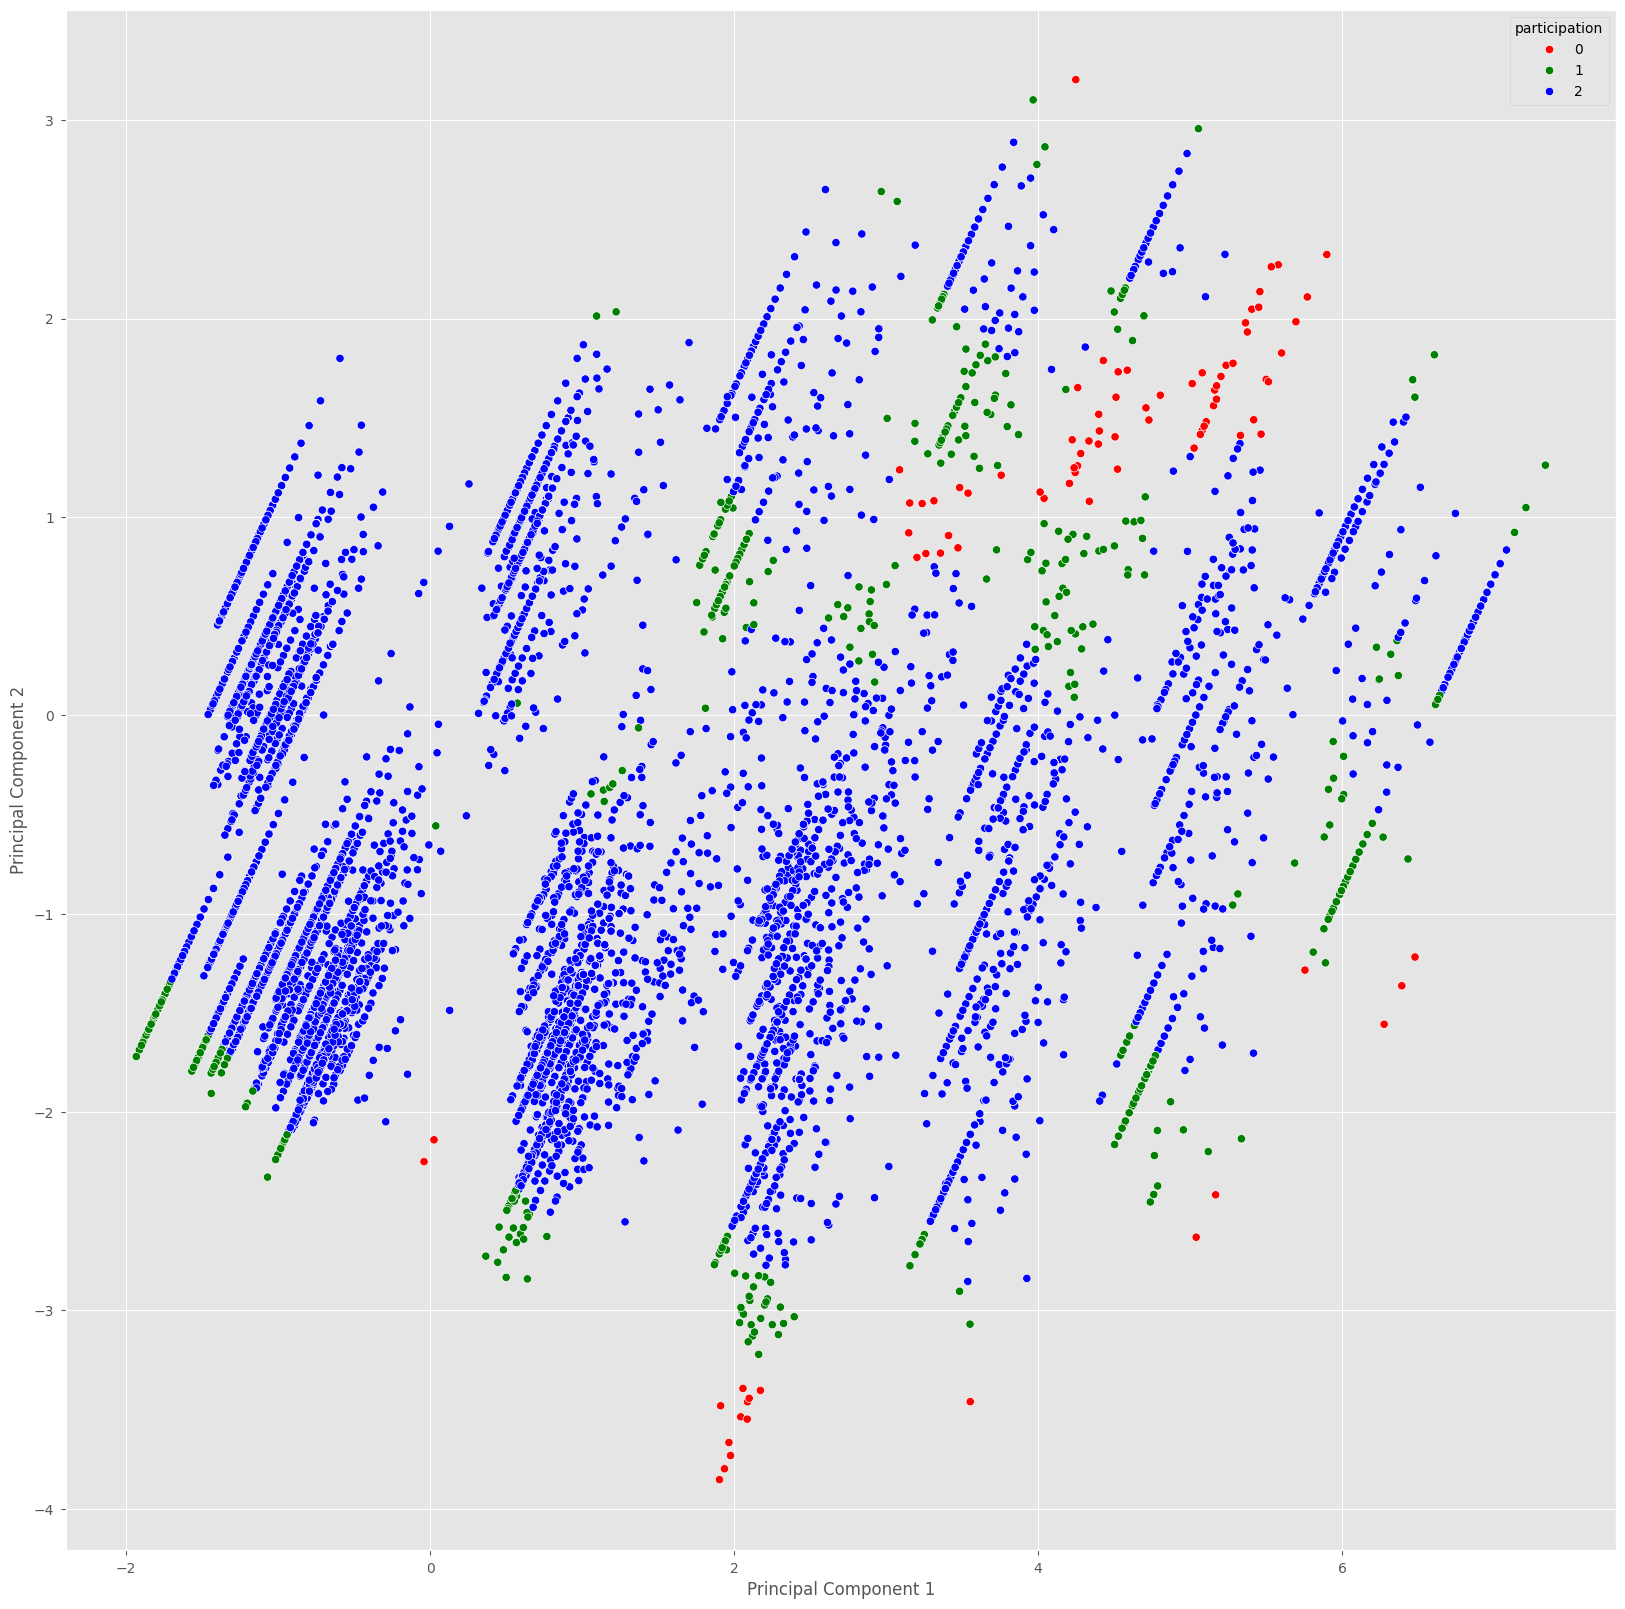

In [56]:
sns.scatterplot(data=pca_df,x='Principal Component 1',y='Principal Component 2',hue='participation',palette=['red', 'green', 'blue'])

In [57]:
sns.scatterplot(data=df,x=0,y=1,hue='participation')

ValueError: Could not interpret value `participation` for `hue`. An entry with this name does not appear in `data`.

In [58]:
pca_df.groupby(['participation'])['id'].count().to_frame()

id
participation       
0                118
1               1713
2              26736

In [59]:
pca_df

Principal Component 1  Principal Component 2  target     id  \
0                   2.507685              -2.644639     1.0      0   
1                   2.311254              -1.051588     1.0      1   
2                  -0.998735               1.121642     0.0      2   
3                  -0.890121               1.302955     0.0      3   
4                  -0.445072              -0.589750     0.0      4   
...                      ...                    ...     ...    ...   
28562              -1.163899               0.845926     0.0  28562   
28563              -0.790517              -1.054533     0.0  28563   
28564               2.219071              -0.875161     1.0  28564   
28565              -0.338128              -0.830394     1.0  28565   
28566              -0.890121               1.302955     1.0  28566   

                             new_column  participation  
0      [cube2_cluster0, cube3_cluster0]              2  
1      [cube3_cluster0, cube4_cluster0]              2  
2      [cube2_cluster1, cube3_cluster0]              2  
3      [cube2_cluster1, cube3_cluster0]              2  
4      [cube1_cluster0, cube2_cluster1]              2  
...                                 ...            ...  
28562  [cube2_cluster1, cube3_cluster0]              2  
28563  [cube0_cluster0, cube1_cluster0]              2  
28564  [cube3_cluster0, cube4_cluster0]              2  
28565  [cube1_cluster0, cube2_cluster1]              2  
28566  [cube2_cluster1, cube3_cluster0]              2  

[28567 rows x 6 columns]

In [61]:
graph['links']

defaultdict(list,
            {'cube0_cluster0': ['cube1_cluster0'],
             'cube1_cluster0': ['cube2_cluster0', 'cube2_cluster1'],
             'cube1_cluster1': ['cube2_cluster0'],
             'cube2_cluster0': ['cube3_cluster0'],
             'cube2_cluster1': ['cube3_cluster0'],
             'cube3_cluster0': ['cube4_cluster0',
              'cube4_cluster1',
              'cube4_cluster2'],
             'cube4_cluster0': ['cube5_cluster0',
              'cube5_cluster1',
              'cube5_cluster2'],
             'cube4_cluster1': ['cube5_cluster1'],
             'cube5_cluster0': ['cube6_cluster0', 'cube6_cluster2'],
             'cube5_cluster1': ['cube6_cluster2'],
             'cube5_cluster2': ['cube6_cluster1'],
             'cube6_cluster0': ['cube7_cluster0'],
             'cube6_cluster1': ['cube7_cluster0', 'cube7_cluster1'],
             'cube6_cluster2': ['cube7_cluster2', 'cube7_cluster3'],
             'cube7_cluster0': ['cube8_cluster0'],
             'cub

In [72]:
g1=graph['links']

In [73]:
from collections import defaultdict

def find_connected_components(graph):
    visited = set()
    components = []

    def dfs(node, component):
        stack = [node]
        while stack:
            current = stack.pop()
            if current not in visited:
                visited.add(current)
                component.append(current)
                for neighbor in graph.get(current, []):
                    if neighbor not in visited:
                        stack.append(neighbor)

    for node in graph.keys():
        if node not in visited:
            component = []
            dfs(node, component)
            components.append(component)

    return components


In [79]:
# Compute H₀
connected_components = find_connected_components(g1)
h_0 = len(connected_components)  # Number of connected components
print(f"H₀: {h_0}")

H₀: 3


In [78]:
def compute_h_1(graph, connected_components):
    num_edges = sum(len(neighbors) for neighbors in graph.values()) // 2  # Each edge counted twice
    num_vertices = len(graph)
    num_components = len(connected_components)

    h_1 = num_edges - num_vertices + num_components
    return h_1
h_1 = compute_h_1(g1, connected_components)
print(f"H₁: {h_1}")

H₁: -3


In [80]:
def compute_h_2():
    # For simple graphs represented by edges only,
    # there are no voids or surfaces.
    return 0
h_2 = compute_h_2()
print(f"H₂: {h_2}")

H₂: 0


In [87]:
# Create the graph using NetworkX
G = nx.Graph(g1)

# Add edges
for node, neighbors in g1.items():
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

# Plot if needed
# nx.draw(G, with_labels=True)

In [89]:
# Convert to the adjacency matrix
A = nx.to_numpy_array(G)

# Compute distances
distances = pairwise_distances(A)

# Fit the homology persistence pipeline
VR = VietorisRipsPersistence(
    homology_dimensions=(0, 1, 2),
    metric="precomputed",
    collapse_edges=True,
)
persistence_diagram = VR.fit_transform([distances])



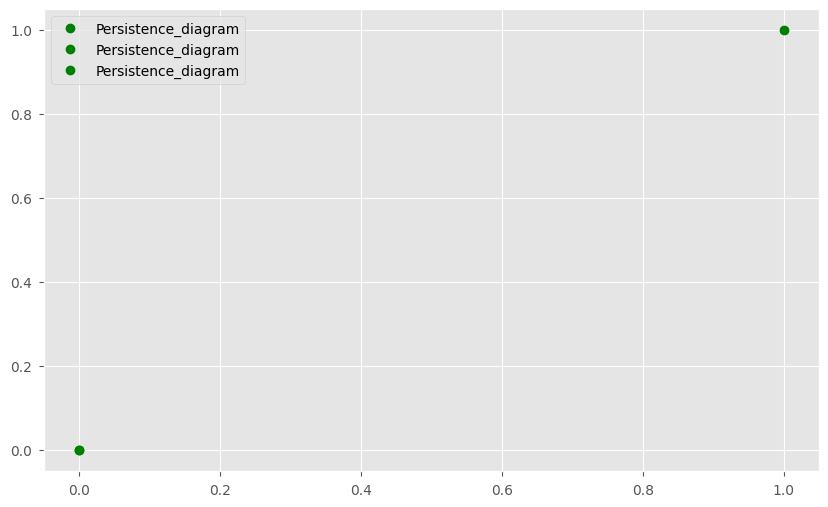

In [90]:
# Plot persistence diagram
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(
    persistence_diagram[:, 0], persistence_diagram[:, 1]
)
ax.plot(
    persistence_diagram[:, 0], persistence_diagram[:, 1], "go", label='Persistence_diagram'
)

plt.legend()
plt.show()

# Optional - Clean up for future 

In [91]:
A

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 

In [92]:
def find_cycles_with_ids(graph):
    def dfs(node, visited, rec_stack, path, cycles):
        # Mark the node as visited and add to recursion stack
        visited.add(node)
        rec_stack.add(node)
        path.append(node)
        
        # Explore neighbors
        for neighbor in graph.get(node, []):
            if neighbor not in visited:
                dfs(neighbor, visited, rec_stack, path, cycles)
            elif neighbor in rec_stack:
                # Cycle found, extract the cycle path
                cycle_start = path.index(neighbor)
                cycle = path[cycle_start:]
                
                # Add cycle to dictionary with a unique loop ID
                loop_id = f"loop_{len(cycles) + 1}"
                cycles[loop_id] = cycle
        
        # Backtrack: Remove the node from the recursion stack and path
        rec_stack.remove(node)
        path.pop()

    visited = set()
    rec_stack = set()
    cycles = {}

    # Run DFS for each node to find cycles
    for node in graph:
        if node not in visited:
            dfs(node, visited, rec_stack, [], cycles)
    
    # Return the dictionary of loops
    return cycles


cycles_dict = find_cycles_with_ids(g1)
print(cycles_dict)

{}


In [93]:
g1

defaultdict(list,
            {'cube0_cluster0': ['cube1_cluster0'],
             'cube1_cluster0': ['cube2_cluster0', 'cube2_cluster1'],
             'cube1_cluster1': ['cube2_cluster0'],
             'cube2_cluster0': ['cube3_cluster0'],
             'cube2_cluster1': ['cube3_cluster0'],
             'cube3_cluster0': ['cube4_cluster0',
              'cube4_cluster1',
              'cube4_cluster2'],
             'cube4_cluster0': ['cube5_cluster0',
              'cube5_cluster1',
              'cube5_cluster2'],
             'cube4_cluster1': ['cube5_cluster1'],
             'cube5_cluster0': ['cube6_cluster0', 'cube6_cluster2'],
             'cube5_cluster1': ['cube6_cluster2'],
             'cube5_cluster2': ['cube6_cluster1'],
             'cube6_cluster0': ['cube7_cluster0'],
             'cube6_cluster1': ['cube7_cluster0', 'cube7_cluster1'],
             'cube6_cluster2': ['cube7_cluster2', 'cube7_cluster3'],
             'cube7_cluster0': ['cube8_cluster0'],
             'cub

In [94]:
undirected_graph = defaultdict(list)

# Add edges in both directions
for node, neighbors in g1.items():
    for neighbor in neighbors:
        # Add edge from node to neighbor
        if neighbor not in undirected_graph[node]:
            undirected_graph[node].append(neighbor)
        # Add reverse edge from neighbor to node
        if node not in undirected_graph[neighbor]:
            undirected_graph[neighbor].append(node)

In [95]:
undirected_graph

defaultdict(list,
            {'cube0_cluster0': ['cube1_cluster0'],
             'cube1_cluster0': ['cube0_cluster0',
              'cube2_cluster0',
              'cube2_cluster1'],
             'cube2_cluster0': ['cube1_cluster0',
              'cube1_cluster1',
              'cube3_cluster0'],
             'cube2_cluster1': ['cube1_cluster0', 'cube3_cluster0'],
             'cube1_cluster1': ['cube2_cluster0'],
             'cube3_cluster0': ['cube2_cluster0',
              'cube2_cluster1',
              'cube4_cluster0',
              'cube4_cluster1',
              'cube4_cluster2'],
             'cube4_cluster0': ['cube3_cluster0',
              'cube5_cluster0',
              'cube5_cluster1',
              'cube5_cluster2'],
             'cube4_cluster1': ['cube3_cluster0', 'cube5_cluster1'],
             'cube4_cluster2': ['cube3_cluster0'],
             'cube5_cluster0': ['cube4_cluster0',
              'cube6_cluster0',
              'cube6_cluster2'],
             'cube5_

In [96]:
cycles_dict = find_cycles_with_ids(undirected_graph)
print(cycles_dict)

{'loop_1': ['cube0_cluster0', 'cube1_cluster0'], 'loop_2': ['cube1_cluster0', 'cube2_cluster0'], 'loop_3': ['cube2_cluster0', 'cube1_cluster1'], 'loop_4': ['cube2_cluster0', 'cube3_cluster0'], 'loop_5': ['cube1_cluster0', 'cube2_cluster0', 'cube3_cluster0', 'cube2_cluster1'], 'loop_6': ['cube3_cluster0', 'cube2_cluster1'], 'loop_7': ['cube3_cluster0', 'cube4_cluster0'], 'loop_8': ['cube4_cluster0', 'cube5_cluster0'], 'loop_9': ['cube5_cluster0', 'cube6_cluster0'], 'loop_10': ['cube6_cluster0', 'cube7_cluster0'], 'loop_11': ['cube4_cluster0', 'cube5_cluster0', 'cube6_cluster0', 'cube7_cluster0', 'cube6_cluster1', 'cube5_cluster2'], 'loop_12': ['cube6_cluster1', 'cube5_cluster2'], 'loop_13': ['cube7_cluster0', 'cube6_cluster1'], 'loop_14': ['cube6_cluster1', 'cube7_cluster1'], 'loop_15': ['cube7_cluster0', 'cube6_cluster1', 'cube7_cluster1', 'cube8_cluster0'], 'loop_16': ['cube7_cluster1', 'cube8_cluster0'], 'loop_17': ['cube8_cluster0', 'cube9_cluster0'], 'loop_18': ['cube5_cluster0', '

In [97]:
loop_1

NameError: name 'loop_1' is not defined

In [98]:
cycles_dict['loop_1']

['cube0_cluster0', 'cube1_cluster0']

In [99]:
cleaned_loops_dict = {
    'loop_1': ['cube2_cluster0', 'cube1_cluster0', 'cube2_cluster1', 'cube3_cluster0'],
    'loop_2': ['cube3_cluster0', 'cube4_cluster1', 'cube5_cluster1', 'cube4_cluster0'],
    'loop_3': ['cube4_cluster0', 'cube5_cluster1', 'cube6_cluster2', 'cube5_cluster0'],
    'loop_4': ['cube5_cluster0', 'cube4_cluster0', 'cube5_cluster2', 'cube6_cluster1', 'cube7_cluster0', 'cube6_cluster0'],
    'loop_5': ['cube7_cluster0', 'cube6_cluster1', 'cube7_cluster1', 'cube8_cluster0']
}

In [100]:
def find_loops_containing_nodes(node_list, loops_dict):
    containing_loops = []
    for loop_id, loop_nodes in loops_dict.items():
        # Check if any node in the node_list is present in the current loop_nodes
        if any(node in loop_nodes for node in node_list):
            containing_loops.append(loop_id)
    return containing_loops

In [101]:
pca_df['loops'] = pca_df['new_column'].apply(lambda nodes: find_loops_containing_nodes(nodes, cleaned_loops_dict))

In [102]:
pca_df

Principal Component 1  Principal Component 2  target     id  \
0                   2.507685              -2.644639     1.0      0   
1                   2.311254              -1.051588     1.0      1   
2                  -0.998735               1.121642     0.0      2   
3                  -0.890121               1.302955     0.0      3   
4                  -0.445072              -0.589750     0.0      4   
...                      ...                    ...     ...    ...   
28562              -1.163899               0.845926     0.0  28562   
28563              -0.790517              -1.054533     0.0  28563   
28564               2.219071              -0.875161     1.0  28564   
28565              -0.338128              -0.830394     1.0  28565   
28566              -0.890121               1.302955     1.0  28566   

                             new_column  participation  \
0      [cube2_cluster0, cube3_cluster0]              2   
1      [cube3_cluster0, cube4_cluster0]              2   
2      [cube2_cluster1, cube3_cluster0]              2   
3      [cube2_cluster1, cube3_cluster0]              2   
4      [cube1_cluster0, cube2_cluster1]              2   
...                                 ...            ...   
28562  [cube2_cluster1, cube3_cluster0]              2   
28563  [cube0_cluster0, cube1_cluster0]              2   
28564  [cube3_cluster0, cube4_cluster0]              2   
28565  [cube1_cluster0, cube2_cluster1]              2   
28566  [cube2_cluster1, cube3_cluster0]              2   

                                  loops  
0                      [loop_1, loop_2]  
1      [loop_1, loop_2, loop_3, loop_4]  
2                      [loop_1, loop_2]  
3                      [loop_1, loop_2]  
4                              [loop_1]  
...                                 ...  
28562                  [loop_1, loop_2]  
28563                          [loop_1]  
28564  [loop_1, loop_2, loop_3, loop_4]  
28565                          [loop_1]  
28566                  [loop_1, loop_2]  

[28567 rows x 7 columns]

In [103]:
pca_df[pca_df['participation']==1]

Principal Component 1  Principal Component 2  target     id  \
16                  5.055273               2.957437     1.0     16   
21                 -1.831059              -1.550498     1.0     21   
31                 -1.850529              -1.582998     0.0     31   
32                 -1.850529              -1.582998     0.0     32   
49                 -1.762194              -1.435538     0.0     49   
...                      ...                    ...     ...    ...   
28453              -1.779264              -1.464032     0.0  28453   
28482               3.363693               1.387226     1.0  28482   
28483              -1.762194              -1.435538     0.0  28483   
28509              -1.768061              -1.445332     0.0  28509   
28533              -1.729692              -1.381281     0.0  28533   

             new_column  participation loops  
16     [cube9_cluster1]              1    []  
21     [cube0_cluster0]              1    []  
31     [cube0_cluster0]              1    []  
32     [cube0_cluster0]              1    []  
49     [cube0_cluster0]              1    []  
...                 ...            ...   ...  
28453  [cube0_cluster0]              1    []  
28482  [cube7_cluster2]              1    []  
28483  [cube0_cluster0]              1    []  
28509  [cube0_cluster0]              1    []  
28533  [cube0_cluster0]              1    []  

[1713 rows x 7 columns]

In [104]:
pca_df['loop_count']=pca_df['loops'].apply(len)

In [107]:
pca_df[pca_df['participation']==1]['loop_count'].value_counts()

loop_count
0    1307
1     265
2     140
3       1
Name: count, dtype: int64

In [108]:
pca_df

Principal Component 1  Principal Component 2  target     id  \
0                   2.507685              -2.644639     1.0      0   
1                   2.311254              -1.051588     1.0      1   
2                  -0.998735               1.121642     0.0      2   
3                  -0.890121               1.302955     0.0      3   
4                  -0.445072              -0.589750     0.0      4   
...                      ...                    ...     ...    ...   
28562              -1.163899               0.845926     0.0  28562   
28563              -0.790517              -1.054533     0.0  28563   
28564               2.219071              -0.875161     1.0  28564   
28565              -0.338128              -0.830394     1.0  28565   
28566              -0.890121               1.302955     1.0  28566   

                             new_column  participation  \
0      [cube2_cluster0, cube3_cluster0]              2   
1      [cube3_cluster0, cube4_cluster0]              2   
2      [cube2_cluster1, cube3_cluster0]              2   
3      [cube2_cluster1, cube3_cluster0]              2   
4      [cube1_cluster0, cube2_cluster1]              2   
...                                 ...            ...   
28562  [cube2_cluster1, cube3_cluster0]              2   
28563  [cube0_cluster0, cube1_cluster0]              2   
28564  [cube3_cluster0, cube4_cluster0]              2   
28565  [cube1_cluster0, cube2_cluster1]              2   
28566  [cube2_cluster1, cube3_cluster0]              2   

                                  loops  loop_count  
0                      [loop_1, loop_2]           2  
1      [loop_1, loop_2, loop_3, loop_4]           4  
2                      [loop_1, loop_2]           2  
3                      [loop_1, loop_2]           2  
4                              [loop_1]           1  
...                                 ...         ...  
28562                  [loop_1, loop_2]           2  
28563                          [loop_1]           1  
28564  [loop_1, loop_2, loop_3, loop_4]           4  
28565                          [loop_1]           1  
28566                  [loop_1, loop_2]           2  

[28567 rows x 8 columns]

In [118]:
#5 columns isin l1 isin l2 isin l3 isin l4 isin l5
pca_df['isinloop_1']=pca_df['loops'].apply(lambda i:1 if 'loop_1' in i else 0)

In [114]:
pca_df['isinloop_1'].value_counts()

isinloop_1
1    23422
0     5145
Name: count, dtype: int64

<Axes: xlabel='Principal Component 1', ylabel='Principal Component 2'>

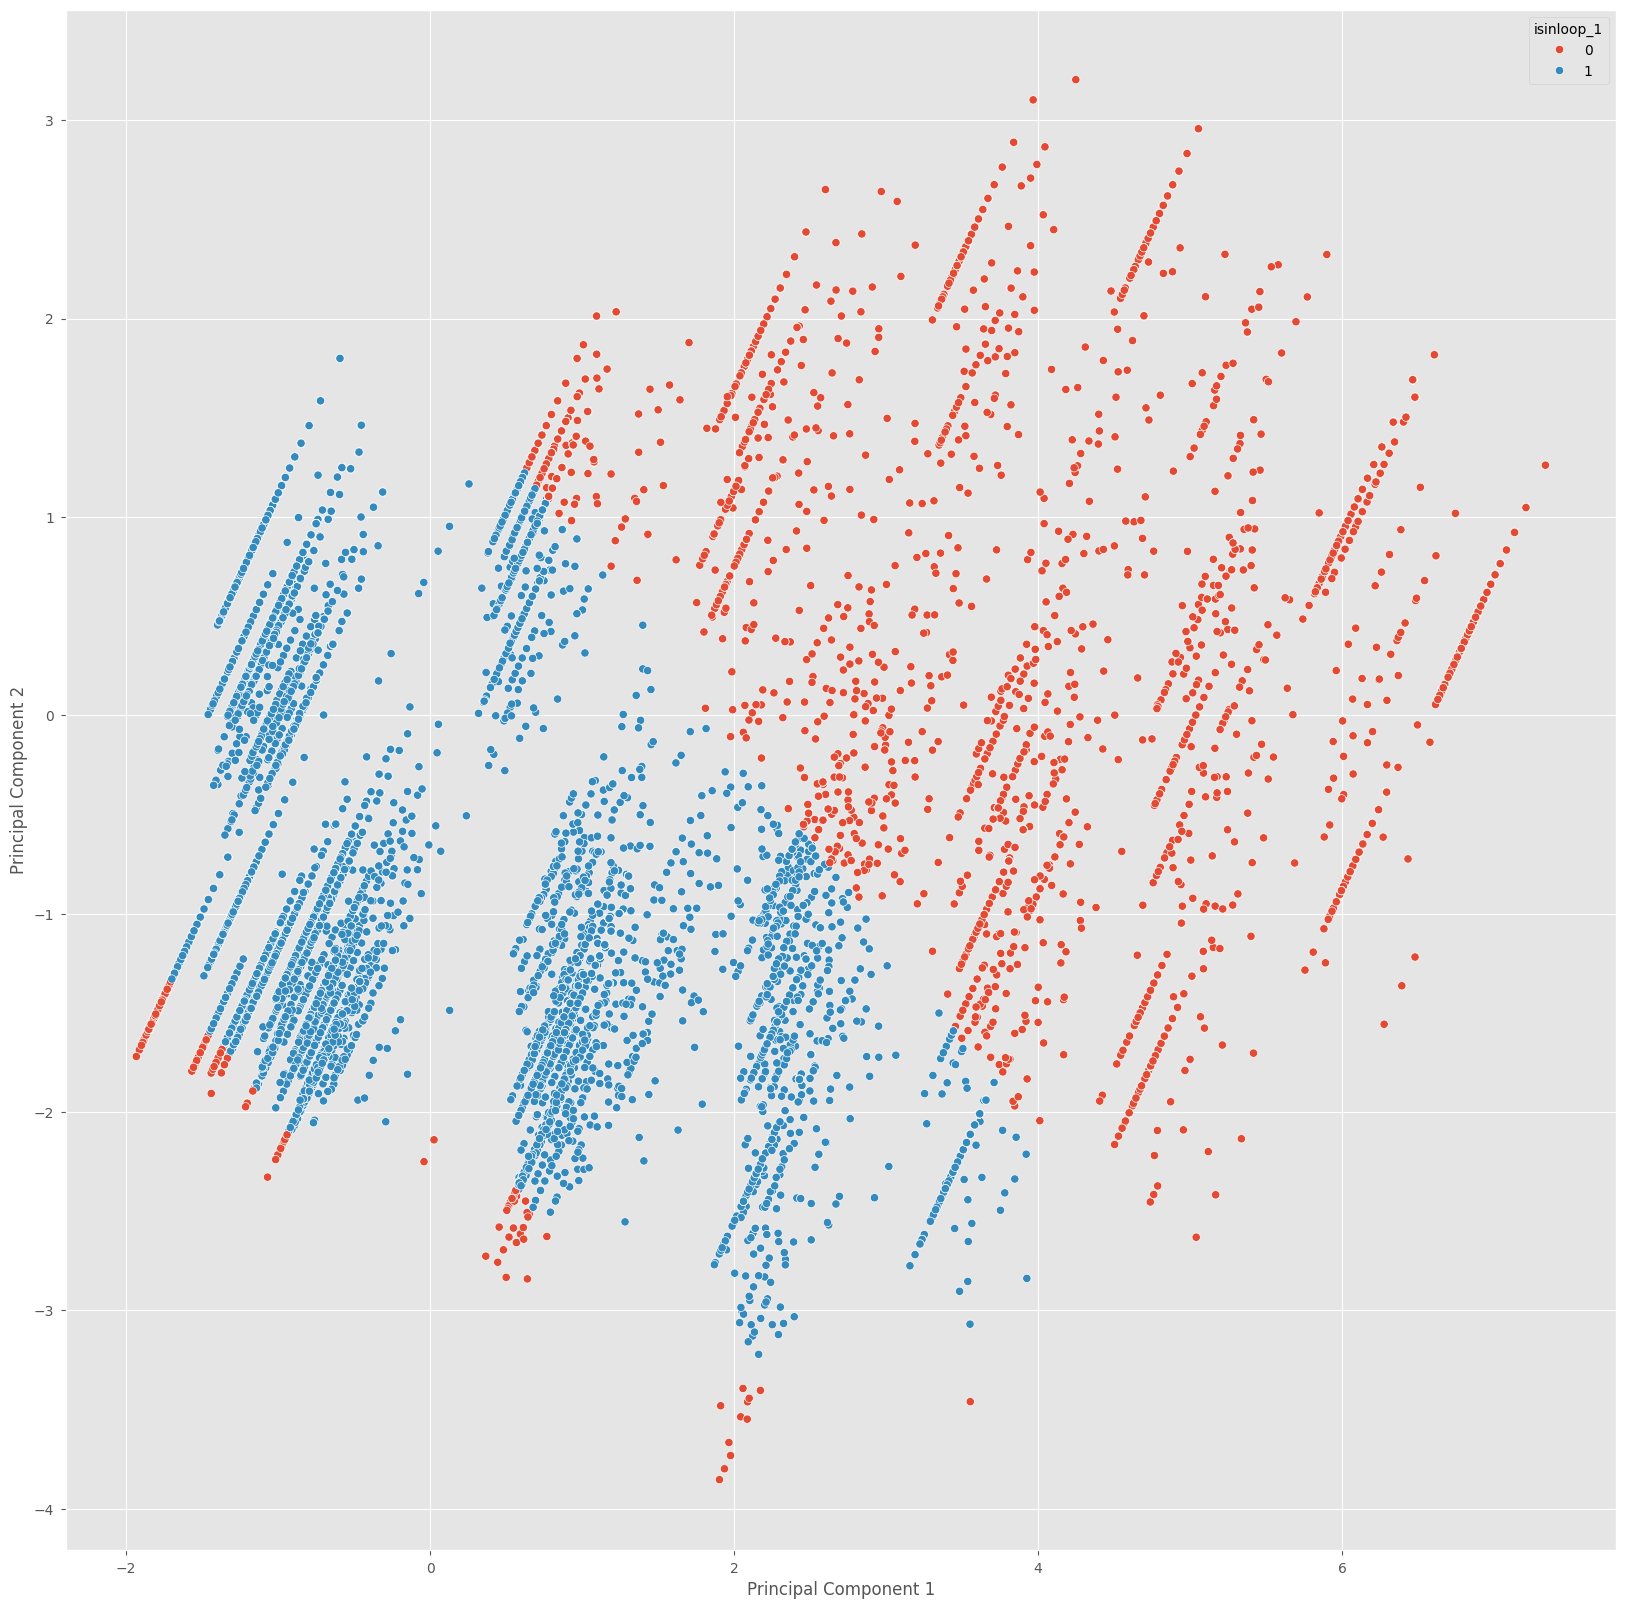

In [115]:
sns.scatterplot(data=pca_df,x='Principal Component 1',y='Principal Component 2', hue='isinloop_1')

In [119]:
pca_df['isinloop_2']=pca_df['loops'].apply(lambda i:1 if 'loop_2' in i else 0)

In [120]:
pca_df['isinloop_3']=pca_df['loops'].apply(lambda i:1 if 'loop_3' in i else 0)

In [121]:
pca_df['isinloop_4']=pca_df['loops'].apply(lambda i:1 if 'loop_4' in i else 0)

In [122]:
pca_df['isinloop_5']=pca_df['loops'].apply(lambda i:1 if 'loop_5' in i else 0)

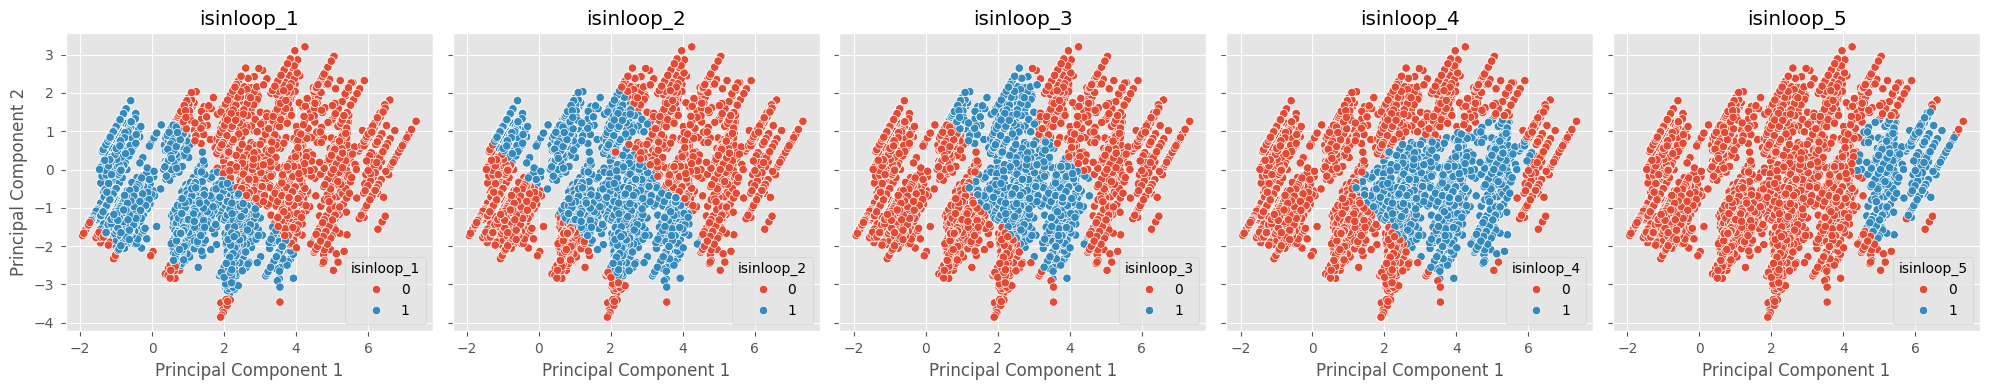

In [124]:
# Set up a figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

# Scatter plots for each pair of variables
sns.scatterplot(ax=axes[0], x='Principal Component 1', y='Principal Component 2', data = pca_df, hue = 'isinloop_1')
axes[0].set_title('isinloop_1')

sns.scatterplot(ax=axes[1], x='Principal Component 1', y='Principal Component 2', data = pca_df, hue = 'isinloop_2')
axes[1].set_title('isinloop_2')

sns.scatterplot(ax=axes[2], x='Principal Component 1', y='Principal Component 2', data = pca_df, hue = 'isinloop_3')
axes[2].set_title('isinloop_3')

sns.scatterplot(ax=axes[3], x='Principal Component 1', y='Principal Component 2', data = pca_df, hue = 'isinloop_4')
axes[3].set_title('isinloop_4')

sns.scatterplot(ax=axes[4], x='Principal Component 1', y='Principal Component 2', data = pca_df, hue = 'isinloop_5')
axes[4].set_title('isinloop_5')

# Adjust layout
plt.tight_layout()
plt.show()

In [125]:
pca_df

Principal Component 1  Principal Component 2  target     id  \
0                   2.507685              -2.644639     1.0      0   
1                   2.311254              -1.051588     1.0      1   
2                  -0.998735               1.121642     0.0      2   
3                  -0.890121               1.302955     0.0      3   
4                  -0.445072              -0.589750     0.0      4   
...                      ...                    ...     ...    ...   
28562              -1.163899               0.845926     0.0  28562   
28563              -0.790517              -1.054533     0.0  28563   
28564               2.219071              -0.875161     1.0  28564   
28565              -0.338128              -0.830394     1.0  28565   
28566              -0.890121               1.302955     1.0  28566   

                             new_column  participation  \
0      [cube2_cluster0, cube3_cluster0]              2   
1      [cube3_cluster0, cube4_cluster0]              2   
2      [cube2_cluster1, cube3_cluster0]              2   
3      [cube2_cluster1, cube3_cluster0]              2   
4      [cube1_cluster0, cube2_cluster1]              2   
...                                 ...            ...   
28562  [cube2_cluster1, cube3_cluster0]              2   
28563  [cube0_cluster0, cube1_cluster0]              2   
28564  [cube3_cluster0, cube4_cluster0]              2   
28565  [cube1_cluster0, cube2_cluster1]              2   
28566  [cube2_cluster1, cube3_cluster0]              2   

                                  loops  loop_count  isinloop_1  isinloop_2  \
0                      [loop_1, loop_2]           2           1           1   
1      [loop_1, loop_2, loop_3, loop_4]           4           1           1   
2                      [loop_1, loop_2]           2           1           1   
3                      [loop_1, loop_2]           2           1           1   
4                              [loop_1]           1           1           0   
...                                 ...         ...         ...         ...   
28562                  [loop_1, loop_2]           2           1           1   
28563                          [loop_1]           1           1           0   
28564  [loop_1, loop_2, loop_3, loop_4]           4           1           1   
28565                          [loop_1]           1           1           0   
28566                  [loop_1, loop_2]           2           1           1   

       isinloop_3  isinloop_4  isinloop_5  
0               0           0           0  
1               1           1           0  
2               0           0           0  
3               0           0           0  
4               0           0           0  
...           ...         ...         ...  
28562           0           0           0  
28563           0           0           0  
28564           1           1           0  
28565           0           0           0  
28566           0           0           0  

[28567 rows x 13 columns]